## Problem Statement

- Northwind Database is a free, public training tool distributed by Microsoft. It details fictional order, shipping and company information for a specialty food retailer.
- We're operating as a consultant, with the goal of improving profits. 
- Two factors could play into that simple statement: we could cut costs, or we could increase revenue. 
- We'll explore two questions from each category above, and move into testing whether or not what we found is statistically significant. 
    

## Questions
- Question 1: Is there a statistically significant difference in discount between categories?
- Question 2: Is there a significant difference in rates between shipping companies? What about by region?
- Question 3: Is there a statistically significant difference in order value by region?
- Question 4: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

What does it mean to be significant? Taken from Hillary Green-Lerman: 
        The difference we're seeing is probably not due to chance.
        "Probably not" here refers to a degree of confidence - typically 5%
        As such, we'll look for p values in each instance below less than .05

In [1]:
import sqlite3 # for database
import numpy as np # analysis
import pandas as pd # for dataframe
import matplotlib.pyplot as plt # plotting
import seaborn as sns # fancy plotting
from scipy import stats # testing
import statsmodels.api as sm # anova
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison) #tukey

In [2]:
# First, let's examine the names of the tables in the database
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()
tables = cur.execute("SELECT name FROM sqlite_master WHERE type = 'table';").fetchall()
tables

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [3]:
# Let's put all of these in pandas dataframes so they're easier to work with

sql_comm = []
for i in range(0,len(tables)):
    s = "SELECT * FROM " + tables[i][0]
    sql_comm.append(s)

employee_df = pd.read_sql_query(sql_comm[0], conn)
category_df = pd.read_sql_query(sql_comm[1], conn)
customer_df = pd.read_sql_query(sql_comm[2], conn)
shipper_df = pd.read_sql_query(sql_comm[3], conn)
supplier_df = pd.read_sql_query(sql_comm[4], conn)
#product_df = pd.read_sql_query(sql_comm[5], conn)
#order_df = pd.read_csv(sql_comm[6])
order_detail_df = pd.read_sql_query(sql_comm[7], conn)
cust_cust_demos_df = pd.read_sql_query(sql_comm[8], conn)
cust_demog_df = pd.read_sql_query(sql_comm[9], conn)
region_df = pd.read_sql_query(sql_comm[10], conn)
territory_df = pd.read_sql_query(sql_comm[11], conn)
emp_territory_df = pd.read_sql_query(sql_comm[12], conn)


In [4]:
# We ran into issues with both order and products - let's do this manually
# For some reason, putting brackets around the title works!
# I didn't figure this out myself - just Googled the issue, since this is a common dataset
cur.execute("SELECT * FROM [Order]")
order_df = pd.DataFrame(cur.fetchall())
order_df.columns = [x[0] for x in cur.description]
order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [5]:
# And again with product
cur.execute("SELECT * FROM [Product]")
product_df = pd.DataFrame(cur.fetchall())
product_df.columns = [x[0] for x in cur.description]
product_df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


Great! We have our dataframes, so onto some analysis!

# Where are the orders going to?

In [10]:
region_orders = pd.read_sql_query('''

                        SELECT ShipRegion, COUNT(O.Id) as OrderCount
                        FROM [Order] as O
                        GROUP BY 1
                        ORDER BY 2 DESC

                        ''',conn)
region_orders

,ShipRegion,OrderCount
0,Western Europe,276
1,North America,152
2,South America,145
3,British Isles,75
4,Southern Europe,64
5,Northern Europe,55
6,Scandinavia,28
7,Central America,28
8,Eastern Europe,7


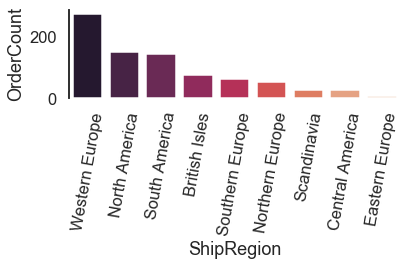

In [11]:
# Let's visualize this one

sns.set(style="white", context="talk")

x = region_orders['ShipRegion']
y1 = region_orders['OrderCount']
ax = sns.barplot(x=x, y=y1, palette="rocket")
plt.setp(ax.get_xticklabels(), rotation=80)

sns.despine(bottom=True)
plt.tight_layout(h_pad=2)


## What about the sales team members, and where they're based?

In [12]:
salespeople = pd.read_sql_query('''

                        SELECT DISTINCT E.LastName, E.FirstName, E.Title, E.Region
                        FROM Employee E
                        GROUP BY 1

                        ''',conn)
salespeople

,LastName,FirstName,Title,Region
0,Buchanan,Steven,Sales Manager,British Isles
1,Callahan,Laura,Inside Sales Coordinator,North America
2,Davolio,Nancy,Sales Representative,North America
3,Dodsworth,Anne,Sales Representative,British Isles
4,Fuller,Andrew,"Vice President, Sales",North America
5,King,Robert,Sales Representative,British Isles
6,Leverling,Janet,Sales Representative,North America
7,Peacock,Margaret,Sales Representative,North America
8,Suyama,Michael,Sales Representative,British Isles


## How many customers are in the dataset? How many orders do they have?

In [13]:
customers = pd.read_sql_query('''

                        SELECT DISTINCT C.CompanyName, C.Region, COUNT(O.Id) as OrderCount
                        FROM Customer C
                        JOIN [Order] O ON C.Id = O.CustomerId
                        GROUP BY 1
                        ORDER BY 3 DESC

                        ''',conn)
customers

,CompanyName,Region,OrderCount
0,Save-a-lot Markets,North America,31
1,Ernst Handel,Western Europe,30
2,QUICK-Stop,Western Europe,28
3,Hungry Owl All-Night Grocers,British Isles,19
4,Folk och fä HB,Northern Europe,19
...,...,...,...
80,Consolidated Holdings,British Isles,3
81,Bólido Comidas preparadas,Southern Europe,3
82,Lazy K Kountry Store,North America,2
83,GROSELLA-Restaurante,South America,2


## What are the categories mentioned?

In [14]:
categories = pd.read_sql_query('''

                        SELECT DISTINCT C.CategoryName, C.Description
                        FROM Category C

                        ''',conn)
categories

,CategoryName,Description
0,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,Confections,"Desserts, candies, and sweet breads"
3,Dairy Products,Cheeses
4,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,Meat/Poultry,Prepared meats
6,Produce,Dried fruit and bean curd
7,Seafood,Seaweed and fish


## What about discounts - what do those look like?
Let's take a look by category.

In [15]:
category_discount = pd.read_sql_query('''

                        SELECT OrderDetail.UnitPrice, Discount, CategoryId FROM OrderDetail
                        JOIN Product
                        ON OrderDetail.ProductId = Product.Id

''',conn)
category_discount.head(10)

,UnitPrice,Discount,CategoryId
0,14.0,0.00,4
1,9.8,0.00,5
2,34.8,0.00,4
3,18.6,0.00,7
4,42.4,0.00,7
5,7.7,0.00,8
6,42.4,0.15,7
7,16.8,0.15,2
8,16.8,0.05,5
9,15.6,0.05,5


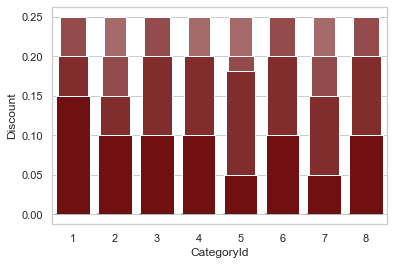

In [16]:
# First, let's visualize what this looks like

sns.set(style="whitegrid")

df = category_discount
sns.boxenplot(x="CategoryId", y="Discount",
              color="maroon",scale="linear", 
              data=df)

# Based on the plot below, we already have some interesting info
# Categories 5 and 6 have the lowest number of "small" discounts - 5%
# Category 1 has the majority of discounts at 15% or below
# All categories seem to have an equal number of 20-25% discounts

# Question 1: Is there a statistically significant difference in discount between categories?

Based on the above, there doesn't appear to be a big enough difference to make this statistically significant. 


$H_0$: There is no difference in discount level between categories.

$H_\alpha$: There is a difference in discount level between categories.

In [17]:
category_discount_test  = category_discount.groupby(['CategoryId']).mean()[['Discount']]
category_discount_test 

,Discount
CategoryId,
1,0.061881
2,0.052639
3,0.056946
4,0.053443
5,0.045306
6,0.064451
7,0.045441
8,0.060242


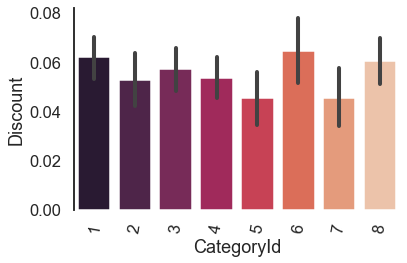

In [22]:
sns.set(style="white", context="talk")

x = category_discount['CategoryId']
y1 = category_discount['Discount']
ax = sns.barplot(x=x, y=y1, palette="rocket")
plt.setp(ax.get_xticklabels(), rotation=80)

sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

Based on the above, the means of the discounts don't look to be that different category by category. Let's move onto testing!

To determime which test we'll run, let's consult Hillary Green-Lerman again:
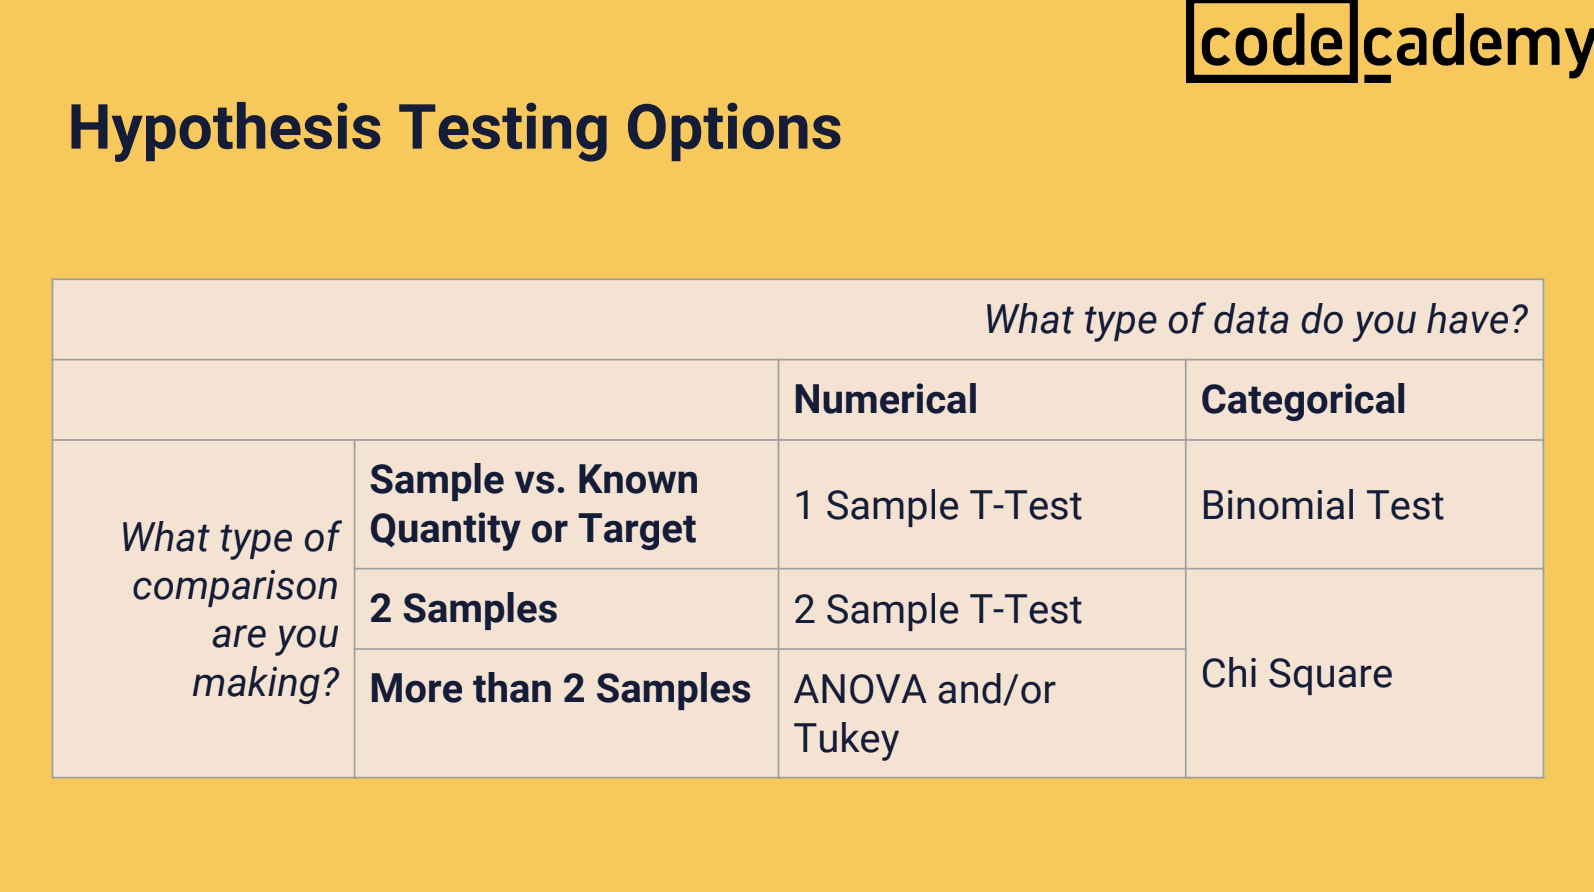

Since this question is about comparing 8 different categories, we'll use ANOVA.

In [23]:
formula = 'Discount ~ C(CategoryId)'
lm = ols(formula, category_discount).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(CategoryId),7.0,0.074918,0.010703,1.539545,0.149326
Residual,2147.0,14.925422,0.006952,NaN,NaN


According to ANOVA, there's no statistical difference between categories. Our p value is .15, which is larger than our threshold of .05. Just for fun, let's run that category by category using tukey:

In [24]:
mc = MultiComparison(category_discount['Discount'],category_discount['CategoryId'])
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0092  0.893 -0.0306 0.0121  False
     1      3  -0.0049    0.9 -0.0236 0.0138  False
     1      4  -0.0084 0.8408 -0.0267 0.0098  False
     1      5  -0.0166 0.3031 -0.0386 0.0054  False
     1      6   0.0026    0.9 -0.0204 0.0256  False
     1      7  -0.0164 0.4901 -0.0415 0.0086  False
     1      8  -0.0016    0.9 -0.0204 0.0171  False
     2      3   0.0043    0.9 -0.0178 0.0264  False
     2      4   0.0008    0.9 -0.0209 0.0225  False
     2      5  -0.0073    0.9 -0.0323 0.0176  False
     2      6   0.0118 0.8491  -0.014 0.0376  False
     2      7  -0.0072    0.9 -0.0349 0.0205  False
     2      8   0.0076    0.9 -0.0145 0.0297  False
     3      4  -0.0035    0.9 -0.0226 0.0156  False
     3      5  -0.0116 0.7517 -0.0344 0.0111  False
     3      6   0.0075    0.9 -0.0162 0.0312  False
     3      

Out of all the category and discount combinations, we're not able to reject any of these null hypotheses.
We expected all of these to be false, given the ANOVA result. 

# Question 2: Are shipping rates significantly different by region?

In [25]:
# First off, what shippers are we working with?
shipper_df.head()

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [26]:
# Let's pull in the shipper details on an order level
ship_details = pd.read_sql_query('''

                        SELECT S.CompanyName, O.Freight, O.ShipRegion, OD.UnitPrice, OD.Quantity
                        FROM [Order] O
                        JOIN OrderDetail OD
                        ON O.Id = OD.OrderID
                        JOIN Shipper S
                        ON S.Id = O.ShipVia

                        ''',conn)
ship_details.head(10)

,CompanyName,Freight,ShipRegion,UnitPrice,Quantity
0,Federal Shipping,32.38,Western Europe,14.0,12
1,Federal Shipping,32.38,Western Europe,9.8,10
2,Federal Shipping,32.38,Western Europe,34.8,5
3,Speedy Express,11.61,Western Europe,18.6,9
4,Speedy Express,11.61,Western Europe,42.4,40
5,United Package,65.83,South America,7.7,10
6,United Package,65.83,South America,42.4,35
7,United Package,65.83,South America,16.8,15
8,Speedy Express,41.34,Western Europe,16.8,6
9,Speedy Express,41.34,Western Europe,15.6,15


We know that freight prices will vary greatly based on distance, weight and other factors.
For now, let's create a value called "CostPerItem" in order to compare these companies.

In [27]:
ship_details['CostPerItem'] = ship_details['Freight'] / ship_details['Quantity']
ship_details.head()

,CompanyName,Freight,ShipRegion,UnitPrice,Quantity,CostPerItem
0,Federal Shipping,32.38,Western Europe,14.0,12,2.698333
1,Federal Shipping,32.38,Western Europe,9.8,10,3.238000
2,Federal Shipping,32.38,Western Europe,34.8,5,6.476000
3,Speedy Express,11.61,Western Europe,18.6,9,1.290000
4,Speedy Express,11.61,Western Europe,42.4,40,0.290250


In [28]:
ship_details.groupby(['CompanyName']).mean()[['CostPerItem']]
# Looking only at the means, it appears that Speedy Express is less expensive
# Let's see if this stays true while we look at the same information with Ship Region

,CostPerItem
CompanyName,
Federal Shipping,5.185212
Speedy Express,4.894073
United Package,5.842993


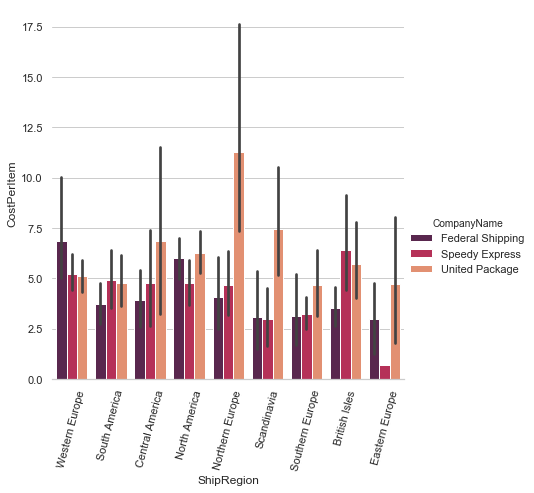

In [29]:
sns.set(style="whitegrid")

g = sns.catplot(x="ShipRegion", y="CostPerItem", hue="CompanyName", data=ship_details,
                height=6, kind="bar", palette="rocket")
g.despine(left=True)
g.set_xticklabels(rotation=75)

This is interesting - from the means above, Speedy Express appears to be less expensive.
This isn't true in a few countries. For example, Federal Shipping is lower in Central America and Northern Europe.
The price of Speedy Express in Eastern Europe looks VERY low - let's investigate that.

In [30]:
# check out values for Speedy Express, Eastern Europe
eastern_europe = pd.read_sql_query('''

                        SELECT O.Freight, O.ShipRegion, OD.UnitPrice, OD.Quantity
                        FROM [Order] O
                        JOIN OrderDetail OD
                        ON O.Id = OD.OrderID
                        JOIN Shipper S
                        ON S.Id = O.ShipVia
                        WHERE S.CompanyName = "Speedy Express"
                        AND O.ShipRegion = "Eastern Europe"

                        ''',conn)
eastern_europe
# Well, it's only one value!
# The CostPerItem for this shipment was indeed low, but it appears to be valid.

,Freight,ShipRegion,UnitPrice,Quantity
0,8.72,Eastern Europe,49.3,12


Again, we're comparing several different samples, so we'll use ANOVA to test if the differences are statistically significant. 

$H_0$: There is no difference in cost per item between companies.

$H_\alpha$: There is a difference in cost per item between companies.

In [31]:
formula = 'CostPerItem ~ C(CompanyName)'
lm = ols(formula, ship_details).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(CompanyName),361.494400,2.0,2.214524,0.109454
Residual,175644.043702,2152.0,NaN,NaN


We're unable to reject the null hypothesis there - our p value is ~0.11.
Let's look at both the shipping company and the region at the same time, since we saw some very big differences in the chart above.

In [32]:
formula = 'CostPerItem ~ C(CompanyName)*C(ShipRegion)'
lm = ols(formula, ship_details).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(CompanyName),335.456854,2.0,2.078114,0.125420
C(ShipRegion),1151.967047,8.0,1.784073,0.075600
C(CompanyName):C(ShipRegion),2737.235122,16.0,2.119604,0.005858
Residual,171754.841533,2128.0,NaN,NaN


Interesting - when we look at both the Region and the Company, the difference is statistically significant!

# A note on impact vs. significance
Just because this shipper difference wasn't found to be significant overall doesn't mean that it's not business-impacting. As we can see above, optimizing for the right carrier in Scandanavia means the difference between paying $2.98 or $7.48 per item!

## Question 3: Is there a significant difference in order value by region?

In [33]:
order_region = pd.read_sql_query('''

                        SELECT OD.Id, OD.UnitPrice, OD.Quantity, OD.Discount, O.ShipRegion
                        FROM OrderDetail OD
                        JOIN [Order] O ON OD.OrderId = O.Id
                        GROUP BY 1, 5

                        ''',conn)
order_region.head()

,Id,UnitPrice,Quantity,Discount,ShipRegion
0,10248/11,14.0,12,0.0,Western Europe
1,10248/42,9.8,10,0.0,Western Europe
2,10248/72,34.8,5,0.0,Western Europe
3,10249/14,18.6,9,0.0,Western Europe
4,10249/51,42.4,40,0.0,Western Europe


In [34]:
order_region['FinalPrice'] = order_region['Quantity']*(order_region['UnitPrice']*(1 - order_region['Discount']))
order_region.head(20)

,Id,UnitPrice,Quantity,Discount,ShipRegion,FinalPrice
0,10248/11,14.0,12,0.00,Western Europe,168.00
1,10248/42,9.8,10,0.00,Western Europe,98.00
2,10248/72,34.8,5,0.00,Western Europe,174.00
3,10249/14,18.6,9,0.00,Western Europe,167.40
4,10249/51,42.4,40,0.00,Western Europe,1696.00
5,10250/41,7.7,10,0.00,South America,77.00
6,10250/51,42.4,35,0.15,South America,1261.40
7,10250/65,16.8,15,0.15,South America,214.20
8,10251/22,16.8,6,0.05,Western Europe,95.76
9,10251/57,15.6,15,0.05,Western Europe,222.30


Let's take a look at the Final Price by ship region. Our first chart will use only the means.

In [39]:
final_by_region = order_region.groupby(['ShipRegion']).mean()[['FinalPrice']]
final_by_region

,FinalPrice
ShipRegion,
British Isles,573.427447
Central America,327.528854
Eastern Europe,220.746875
North America,692.695317
Northern Europe,609.483654
Scandinavia,350.645750
South America,484.100015
Southern Europe,330.114726
Western Europe,678.072897


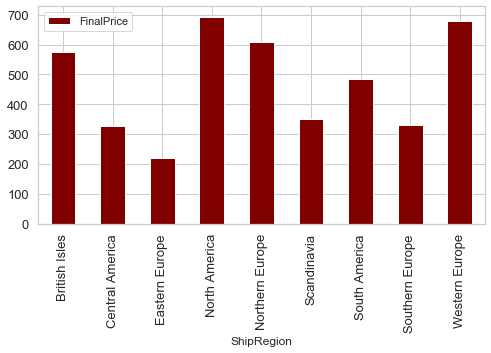

In [40]:
ax = final_by_region.plot(kind='bar', figsize=(8,4), color="maroon", fontsize=13);
ax.set_alpha(0.8)
plt.show()

To make sure we capture any variance, let's also use a Seaborn bar chart with error bars.

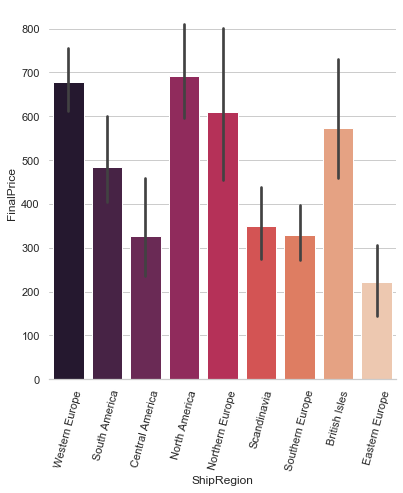

In [36]:
sns.set(style="whitegrid")

g = sns.catplot(x="ShipRegion", y="FinalPrice", data=order_region,
                height=6, kind="bar", palette="rocket")
g.despine(left=True)
g.set_xticklabels(rotation=75)

Again, we're comparing multiple regions, so we'll use ANOVA. 

$H_0$: Ship region has no impact on the final order price.

$H_\alpha$: Ship region does have an impact on the final order price.

In [37]:
formula = 'FinalPrice ~ C(ShipRegion)'
lm = ols(formula, order_region).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(ShipRegion),8.0,3.476009e+07,4.345011e+06,4.688692,0.00001
Residual,2146.0,1.988698e+09,9.266999e+05,NaN,NaN


Our p value is very close to 0 - that means there is a significant diffence in means between regions!

In [38]:
mc = MultiComparison(order_region['FinalPrice'], order_region['ShipRegion'])
result = mc.tukeyhsd()
print(result)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
     group1          group2      meandiff p-adj    lower      upper   reject
----------------------------------------------------------------------------
  British Isles Central America -245.8986 0.6307  -659.5434  167.7462  False
  British Isles  Eastern Europe -352.6806 0.8964 -1130.7472  425.3861  False
  British Isles   North America  119.2679 0.8883  -141.3906  379.9263  False
  British Isles Northern Europe   36.0562    0.9  -294.8442  366.9566  False
  British Isles     Scandinavia -222.7817 0.7462  -640.6898  195.1264  False
  British Isles   South America  -89.3274    0.9  -358.0024  179.3476  False
  British Isles Southern Europe -243.3127 0.3719   -578.322   91.6965  False
  British Isles  Western Europe  104.6454    0.9  -138.2788  347.5697  False
Central America  Eastern Europe  -106.782    0.9  -932.8867  719.3227  False
Central America   North America  365.1665 0.0725   -15.6275  745.9604  False

## Question 4: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

First off, let's break this data into two groups - orders that have discounts and orders that do not. From there, we'll compare the average quantity to see if the difference is significant.

In [102]:
discount = order_detail_df.loc[order_detail_df['Discount'] > 0]
full_price = order_detail_df.loc[order_detail_df['Discount'] == 0]

In [103]:
print(discount.info())
print(full_price.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 838 entries, 6 to 2152
Data columns (total 6 columns):
Id           838 non-null object
OrderId      838 non-null int64
ProductId    838 non-null int64
UnitPrice    838 non-null float64
Quantity     838 non-null int64
Discount     838 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 45.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1317 entries, 0 to 2154
Data columns (total 6 columns):
Id           1317 non-null object
OrderId      1317 non-null int64
ProductId    1317 non-null int64
UnitPrice    1317 non-null float64
Quantity     1317 non-null int64
Discount     1317 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 72.0+ KB
None


In [104]:
display(discount.head())
display(full_price.head())

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05
11,10252/20,10252,20,64.8,40,0.05


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [44]:
print('Full price mean:', full_price.Quantity.mean())
print('Discount mean:', discount.Quantity.mean())

Full price mean: 21.715261958997722
Discount mean: 27.10978520286396


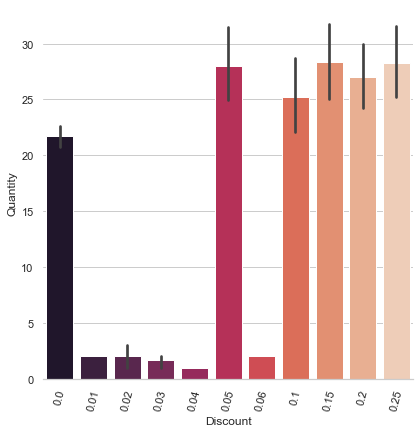

In [46]:
# visualize this
sns.set(style="whitegrid")

g = sns.catplot(x="Discount", y="Quantity", data=order_detail_df,
                height=6, kind="bar", palette="rocket")
g.despine(left=True)
g.set_xticklabels(rotation=75)

Looking at our info all together, we see a few things:
1. Very low numbers of discounts 1%-4% and 6% (but we already knew this!)
2. More importantly, the quantity for 0% discount appears to be lower than with a discount. 

This will inform our hypothesis.

These means are different, but we don't know if they're different enough to be statistically significant. Since we're only testing two sets against each other, we'll use a 2 sample t test, Welch's t test and Cohen's d instead of ANOVA.

𝐻0 : There is no difference in quantity ordered with respect to discount level.

𝐻𝛼 : Discount level does impact the quantity ordered.

In [47]:
# t test
stats.ttest_ind(discount.Quantity.values, full_price.Quantity.values)

Ttest_indResult(statistic=6.4785631962949015, pvalue=1.1440924523215966e-10)

In [48]:
# welch's t test
# needed because it's more reliable when samples have unequal variances
stats.ttest_ind(discount.Quantity.values, full_price.Quantity.values, equal_var=False)

Ttest_indResult(statistic=6.239069142123973, pvalue=5.65641429030433e-10)

Both of these p values are very small - almost near zero! We're able to reject the null hypothesis here, and assume that the discount of an order does impact the quantity.

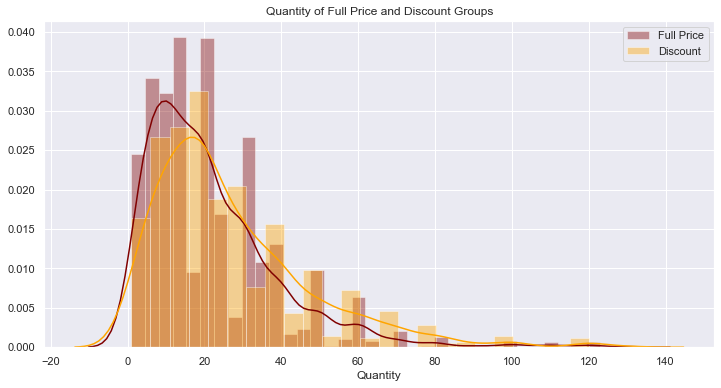

In [56]:
# visualize kde plots for both groups
sns.set(color_codes = True)
sns.set(rc={'figure.figsize':(12,6)})

sns.distplot(full_price.Quantity, label = "Full Price", color="maroon")
sns.distplot(discount.Quantity, label = "Discount", color="orange")

plt.title('Quantity of Full Price and Discount Groups')
plt.legend()
plt.show()

In [57]:
# cohen's d
def cohens_d(group1, group2):
    """
    Returns the Cohen's D, or the measurment between the means of two groups. 
    This is used as a way to measure the effect size between two samples.
    
    Note
    --------
    The below can be used as interprepation of Cohen's D:
    Small: 0.2
    Medium: 0.5
    Large 0.8
    Very Large 1.3
    """    
    num = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    denom = np.sqrt(pooled_var)
    return num / denom
cohens_d(discount.Quantity, full_price.Quantity)

0.2862724481729283

Cohen's D is a way to interpret the effect size - in other words, we're measuring not just that these sets differ from each other, but *how much* they differ. 
According to NIH (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3444174/), an effect size of .28 is small to medium. 

## Yes, there is a difference in quantity between orders that have discounts and those that don't! It appears that orders *with* discounts have a higher quantity. 
## Next up: what levels of discount are statistically significant?

In [58]:
discount_levels = order_detail_df['Discount'].unique()
discount_levels.sort()
print('Discount Levels:')
print(discount_levels)

Discount Levels:
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.1  0.15 0.2  0.25]


In [59]:
order_detail_df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [60]:
# Group orders by discount amounts
# Each group is a DataFrame containing orders with certain discount level
groups = {}
for i in discount_levels:
    groups[i] = order_detail_df[order_detail_df['Discount']==i]

In [61]:
discounts_df = pd.DataFrame(columns=['Discount %','Orders','Avg. Order Quantity'])

for i in groups.keys():
    discounts_df = discounts_df.append({'Discount %':i*100,'Orders':len(groups[i]),'Avg. Order Quantity':groups[i]['Quantity'].mean()}, ignore_index=True)

discounts_df

,Discount %,Orders,Avg. Order Quantity
0,0.0,1317.0,21.715262
1,1.0,1.0,2.000000
2,2.0,2.0,2.000000
3,3.0,3.0,1.666667
4,4.0,1.0,1.000000
5,5.0,185.0,28.010811
6,6.0,1.0,2.000000
7,10.0,173.0,25.236994
8,15.0,157.0,28.382166
9,20.0,161.0,27.024845


In [62]:
order_detail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


As we see above, the discount levels of 1%, 2%, 3%, 4% and 6% have relatively few orders
Let's "round" these to 5%

In [63]:
order_detail_df['Discount'] = order_detail_df['Discount'].apply(lambda x: .05 if (x > 0) & (x < .10) else x)
order_detail_df['Discount'].value_counts()

0.00    1317
0.05     193
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

In [105]:
order_detail_df.head(20)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.00
1,10248/42,10248,42,9.8,10,0.00
2,10248/72,10248,72,34.8,5,0.00
3,10249/14,10249,14,18.6,9,0.00
4,10249/51,10249,51,42.4,40,0.00
5,10250/41,10250,41,7.7,10,0.00
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05


Since we're comparing multiple discount levels, we'll use ANOVA again.

In [64]:
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, order_detail_df).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(Discount),5.0,15969.214452,3193.842890,8.990431,1.816734e-08
Residual,2149.0,763430.421743,355.249149,NaN,NaN


Our p value is VERY small. Let's run this with tukey too. 

In [65]:
mc = MultiComparison(order_detail_df['Quantity'], order_detail_df['Discount'])
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0   0.05    5.207 0.0047  1.0635  9.3506   True
   0.0    0.1   3.5217   0.19 -0.8257  7.8692  False
   0.0   0.15   6.6669  0.001  2.1279 11.2059   True
   0.0    0.2   5.3096 0.0098  0.8212  9.7979   True
   0.0   0.25    6.525  0.001  1.9467 11.1033   True
  0.05    0.1  -1.6853    0.9 -7.3138  3.9432  False
  0.05   0.15   1.4599    0.9 -4.3179  7.2377  False
  0.05    0.2   0.1026    0.9 -5.6355  5.8406  False
  0.05   0.25    1.318    0.9 -4.4907  7.1267  False
   0.1   0.15   3.1452 0.6347 -2.7805  9.0709  False
   0.1    0.2   1.7879    0.9 -4.0991  7.6748  False
   0.1   0.25   3.0033 0.6783 -2.9526  8.9591  False
  0.15    0.2  -1.3573    0.9 -7.3872  4.6725  False
  0.15   0.25  -0.1419    0.9  -6.239  5.9552  False
   0.2   0.25   1.2154    0.9 -4.8441  7.2749  False
----------------------------------------------

Interesting - we've already determined that a discount does impact the quantity of items ordered. As we see in the tukey above, the discount levels of 5%, 15%, 20% and 25% have quantities significantly different than no discount.

Let's run another tukey, but this time label the groups.

In [66]:
def pairwise_tukeyhsd(endog, groups, alpha=0.05):
    """
    Calculate all defined combinations with tukeyHSD confidence intervals

    Parameters
    ----------
    endog : ndarray, float, 1d
        response variable
    groups : ndarray, 1d
        array with groups, can be string or integers
    alpha : float
        significance level for the test

    Returns
    -------
    results : TukeyHSDResults instance
        A results class containing relevant data and some post-hoc
        calculations, including adjusted p-value
    """
    return MultiComparison(endog, groups).tukeyhsd(alpha=alpha)

In [92]:
order_detail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


The dataframe we're working with has some unnecessary info. Let's drop the columns we don't need.

In [140]:
tukey2_df = order_detail_df.copy()
tukey2_df = tukey2_df.drop(['Id', 'OrderId', 'ProductId', 'UnitPrice'], axis=1)
tukey2_df.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


Perfect! Now let's name the groups and convert them into lists.

In [136]:
zeroes = tukey2_df[order_detail_df['Discount']==0.0]
fives = tukey2_df[order_detail_df['Discount']==0.05]
tens = tukey2_df[order_detail_df['Discount']==0.10]
fifteens = tukey2_df[order_detail_df['Discount']==0.15]
twenties = tukey2_df[order_detail_df['Discount']==0.20]
twentyfives = tukey2_df[order_detail_df['Discount']==0.25]

In [137]:
zeroes_list = zeroes.values.tolist()
fives_list = fives.values.tolist()
tens_list = tens.values.tolist()
fifteens_list = fifteens.values.tolist()
twenties_list = twenties.values.tolist()
twentyfives_list = twentyfives.values.tolist()

Finally, let's run the tukey again with the labeled, concatenated lists.

In [139]:
v = np.concatenate([zeroes_list, fives_list, tens_list, fifteens_list, twenties_list, twentyfives_list])
labels = ['No Discount'] * len(zeroes_list) + ['5%'] * len(fives_list) + ['10%']*len(tens_list) + ['15%']*len(fifteens_list) + ['20%']*len(twenties_list) + ['25%']*len(twentyfives_list)
tukey2 = pairwise_tukeyhsd(v, labels, .05)
print (tukey2)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   10%         15%    5.207 0.0047  1.0635  9.3506   True
   10%         20%   3.5217   0.19 -0.8257  7.8692  False
   10%         25%   6.6669  0.001  2.1279 11.2059   True
   10%          5%   5.3096 0.0098  0.8212  9.7979   True
   10% No Discount    6.525  0.001  1.9467 11.1033   True
   15%         20%  -1.6853    0.9 -7.3138  3.9432  False
   15%         25%   1.4599    0.9 -4.3179  7.2377  False
   15%          5%   0.1026    0.9 -5.6355  5.8406  False
   15% No Discount    1.318    0.9 -4.4907  7.1267  False
   20%         25%   3.1452 0.6347 -2.7805  9.0709  False
   20%          5%   1.7879    0.9 -4.0991  7.6748  False
   20% No Discount   3.0033 0.6783 -2.9526  8.9591  False
   25%          5%  -1.3573    0.9 -7.3872  4.6725  False
   25% No Discount  -0.1419    0.9  -6.239  5.9552  False
    5% No Disc

# Future Work

Analysis:
- Calculate money/etc. saved by solution, rather than just suggesting

Testing:
- Write a function to spit out *only* trues from tukey
- None of these datasets required resampling; choose the smallest (by number of entries) and investigate if bootlegging changes the outcome